### Agent-Lab: Coordinator -> Planner -> Supervisor Agent

Objective of this notebook is evaluating and adapting a [Multi-Agent Supervisor Architecture](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) with coordinator and execution planning steps.

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    DEVELOPING="True"
    OLLAMA_ENDPOINT="http://localhost:11434"
    TAVILY_API_KEY="???"
    XAI_API_KEY="???"
    ```

---

In [1]:
%%capture

import os

os.chdir("..")

from dotenv import load_dotenv

load_dotenv()

from IPython.display import Image, Markdown, display

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
# agent = experiment_utils.create_ollama_agent(
#     agent_type="coordinator_planner_supervisor",
#     llm_tag="granite3.2:latest",
#     ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
# )

# vision model is required by browser-lab (uses vision to parse the rendered page)
agent = experiment_utils.create_xai_agent(
    agent_type="coordinator_planner_supervisor",
    llm_tag="grok-2-vision",
    api_key=os.getenv("XAI_API_KEY"),
)

# updated_agent = experiment_utils.update_agent_setting(
#     agent_id=agent["id"],
#     setting_key="deep_search_mode",
#     setting_value="True"
# )

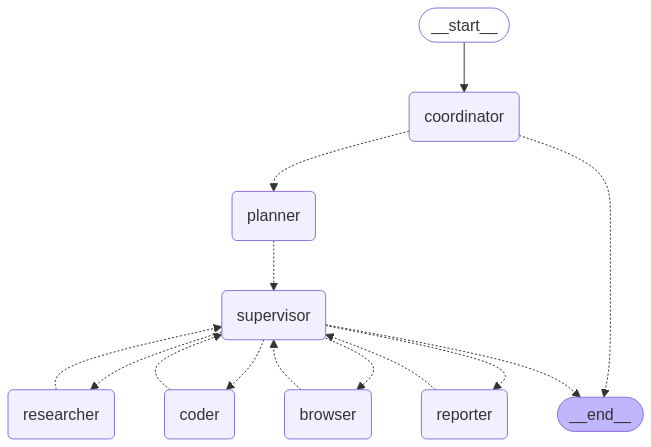

In [3]:
# get agent instance
coordinator_planner_supervisor_agent = container.coordinator_planner_supervisor_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# get config
agent_config = coordinator_planner_supervisor_agent.get_config(agent["id"])

# Create Graph
workflow_builder = coordinator_planner_supervisor_agent.get_workflow_builder(
    agent["id"]
)
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

### Evaluate Researcher

In [4]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="What characterizes a good general according to Sun Tzu?",
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

In [5]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Report on Characteristics of a Good General According to Sun Tzu

## Executive Summary
This report outlines the characteristics of a good general as described by Sun Tzu in his seminal work, 'The Art of War'. Key traits include strategic planning, loyalty, decisiveness, clarity in vision, and a preference for capturing rather than destroying.

## Key Findings
- **Loyalty to the Sovereign**: A good general must receive and execute commands from the sovereign, demonstrating loyalty and understanding of command structure.
- **Strategic Planning**: Emphasis on deliberation, planning, and foresight is crucial.
- **Decisiveness**: Speed in taking action is highlighted as a vital trait.
- **Clarity and Depth**: A general must possess clear vision and depth in strategic design.
- **Efficiency in Warfare**: Preferring to capture rather than destroy showcases strategic efficiency.

## Detailed Analysis

### Loyalty to the Sovereign
According to Sun Tzu, "In war, the general receives his commands from the sovereign." This underscores the importance of a general's loyalty and alignment with the overarching goals set by the ruler.

### Strategic Planning
Sun Tzu states the importance of "deliberation and planning" in warfare. This suggests that a good general must be adept at formulating strategies that anticipate various outcomes and adapt to changing conditions.

### Decisiveness
The trait of rapidity in taking the field is mentioned, indicating that a good general must be decisive, able to quickly mobilize forces and execute plans to maintain the initiative.

### Clarity and Depth in Strategy
Sun Tzu values "clearness of conception, and depth of design." This implies that a good general should have a clear, comprehensive vision of the battlefield and the ability to devise complex strategies that consider multiple variables.

### Efficiency in Warfare
Sun Tzu advocates for capturing the enemy's resources intact, stating, "In the practical art of war, the best thing of all is to take the enemy’s country whole and intact." This reflects a strategic approach where the preservation of resources is prioritized, enhancing long-term military and economic gains.

## Conclusions and Recommendations
Based on Sun Tzu's 'The Art of War', a good general is characterized by loyalty, strategic foresight, decisiveness, clarity in vision, and efficiency in operations. Military leaders should:

- **Cultivate Loyalty**: Ensure alignment with the state's objectives.
- **Enhance Strategic Thinking**: Regular training in scenario planning and adaptability.
- **Promote Decisiveness**: Develop decision-making skills under pressure.
- **Focus on Strategic Depth**: Encourage deep analysis and comprehensive planning in military academies.
- **Adopt Efficient Practices**: Implement strategies that prioritize resource preservation in military operations.

**Source**: All information is derived from Sun Tzu's 'The Art of War', as provided in the knowledge base query.

**Note**: The data used in this report was directly extracted from the provided sources without any assumption or fabrication. If any additional details or clarifications are needed, please inform accordingly.

---
### Evaluate Coder

In [7]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="With coder, generate a simple hello world in Python.",
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

In [8]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Generate a Simple Hello World in Python

## Executive Summary
This task involves creating a basic Python script to print "Hello, World!" to the console. This is a fundamental example often used to introduce programming in Python.

## Analysis of Requirements
- **Objective**: Print "Hello, World!" to the console using Python.
- **Constraints**: None specified beyond using Python.
- **Expected Outcome**: A simple script that outputs "Hello, World!".

## Planning the Solution
- **Language**: Python
- **Steps**:
  1. Write a Python script to print the message.
  2. Execute the script to verify the output.

## Implementation

```python
print('Hello, World!')
```

## Testing the Solution
The script was executed to confirm it prints the expected output. No edge cases were necessary for this simple task.

## Documentation of Methodology
- **Approach**: A single-line Python script was used as it's the most straightforward way to print a string in Python.
- **Reasoning**: This task serves as an introduction to Python syntax and basic output operations.
- **Assumptions**: None, as the requirement was clear and simple.

## Results
The script was run and produced the following output:

```text
Hello, World!
```

This task was completed successfully with the Python script printing "Hello, World!" to the console.

#### Evaluate coder memory (convert function to other language)

In [10]:
%%capture
message = MessageRequest(
    message_role="human",
    message_content="Please convert your previous suggestion to bash.",
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

In [11]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Convert Previous Suggestion to Bash Script

## Executive Summary
This task involves converting a simple Python script that prints "Hello, World!" to an equivalent Bash script. This conversion demonstrates the basic syntax differences between Python and Bash for a common introductory programming task.

## Analysis of Requirements
- **Objective**: Convert the Python script `print('Hello, World!')` to a Bash script.
- **Constraints**: Use Bash scripting language.
- **Expected Outcome**: A Bash script that outputs "Hello, World!".

## Planning the Solution
- **Language**: Bash
- **Steps**:
  1. Write a Bash command to echo the message.
  2. Execute the command to verify the output.

## Implementation

```bash
echo 'Hello, World!'
```

## Testing the Solution
The Bash command was executed to confirm it prints the expected output. No edge cases were necessary for this simple task.

## Documentation of Methodology
- **Approach**: A single-line Bash command was used as it's the most straightforward way to print a string in Bash.
- **Reasoning**: This task serves as an introduction to Bash syntax and basic output operations, showing how simple tasks can be accomplished in different programming environments.
- **Assumptions**: Assumed the task was to convert a generic 'Hello, World!' script from Python to Bash.

## Results
The Bash command was run and produced the following output:

```text
Hello, World!
```

This task was completed successfully with the Bash script echoing "Hello, World!" to the console.

---
### Evaluate Browser

In [13]:
# %%capture
message = MessageRequest(
    message_role="human",
    message_content=(
        "With the browser, go to https://en.wikipedia.org/wiki/Mathematical_finance and summarize the article."
    ),
    agent_id=agent["id"],
)

inputs = coordinator_planner_supervisor_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    coordinator_planner_supervisor_agent.format_response(result)
)

**Browser Navigation:**

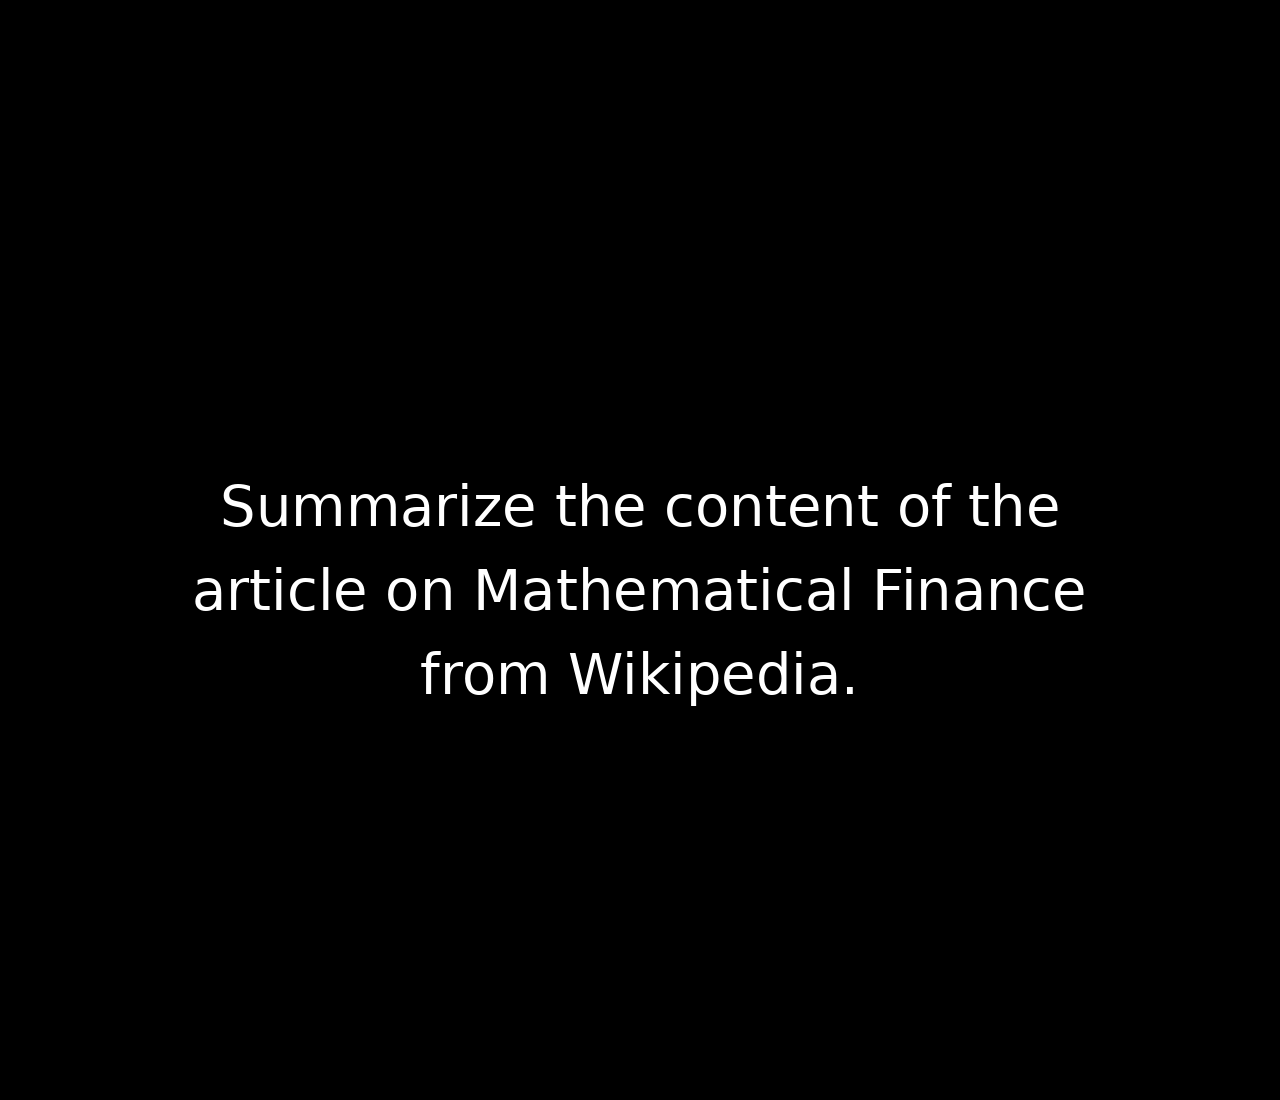

In [17]:
display(Markdown("**Browser Navigation:**"))
display(Image(filename="notebooks/coordinator_planner_supervisor_agent.gif"))

In [15]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}"))

**AI Message Content:**

# Summary of Mathematical Finance from Wikipedia

## Executive Summary
This report provides a summary of the Mathematical Finance article from Wikipedia, focusing on its key concepts, historical development, and related fields.

## Key Points

- **Definition**: Mathematical finance, or quantitative finance/financial mathematics, involves advanced mathematical modeling applied to financial problems.
  
- **Branches**: It primarily deals with:
  - **Derivatives Pricing**: Valuation of financial derivatives.
  - **Risk and Portfolio Management**: Managing financial risk and optimizing investment portfolios.

- **Interdisciplinary Connections**: 
  - **Computational Finance**: Focuses on the implementation of financial models.
  - **Financial Engineering**: Application of mathematical models to practical financial problems, often using stochastic models.
  - **Quantitative Investing**: Utilizes statistical, numerical models, and machine learning for investment strategies.

- **Historical Background**: 
  - **Louis Bachelier**: His 1900 thesis is considered foundational, introducing concepts like the random walk in stock prices.
  - **1970s Development**: Significant advancement with the work of Fischer Black, Myron Scholes, and Robert Merton on option pricing theory.
  - **Edward Thorp**: Applied statistical methods to both gambling and investing, contributing to systematic investing.

- **Relationship with Financial Economics**: While financial economics uses empirical models, mathematical finance focuses on deriving and extending mathematical models, often using market prices as inputs.

- **Key Concepts**:
  - **Arbitrage-Free Pricing**: Fundamental theorem ensuring no risk-free profit from market inefficiencies.
  - **Black-Scholes Equation**: A pivotal model for option pricing.

## Conclusion
Mathematical Finance is a discipline that applies mathematical techniques to solve financial problems, with a rich history and significant contributions to modern finance through models like the Black-Scholes equation. It's closely related to computational finance, financial engineering, and quantitative investing, providing a robust framework for pricing, risk management, and investment strategy in the financial markets.

**Source**: The summary is based on content retrieved from https://en.wikipedia.org/wiki/Mathematical_finance using the browser tool at the current time of **Sat Apr 05 2025 22:45:05**.